# Explore here

In [925]:
# Your code here

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score
from joblib import dump


df: pd.DataFrame = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv", delimiter=",")
df.head()



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [926]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [927]:
if df.duplicated().sum() > 0:
    print("There are duplicated rows\n")
    df.drop_duplicates(inplace=True)
else:
    print("There are no duplicated rows\n")

if df.isnull().sum().sum() > 0:
    print("There are missing values\n")
    df.dropna(inplace=True)
else:
    print("There are no missing values\n")

There are no duplicated rows

There are no missing values



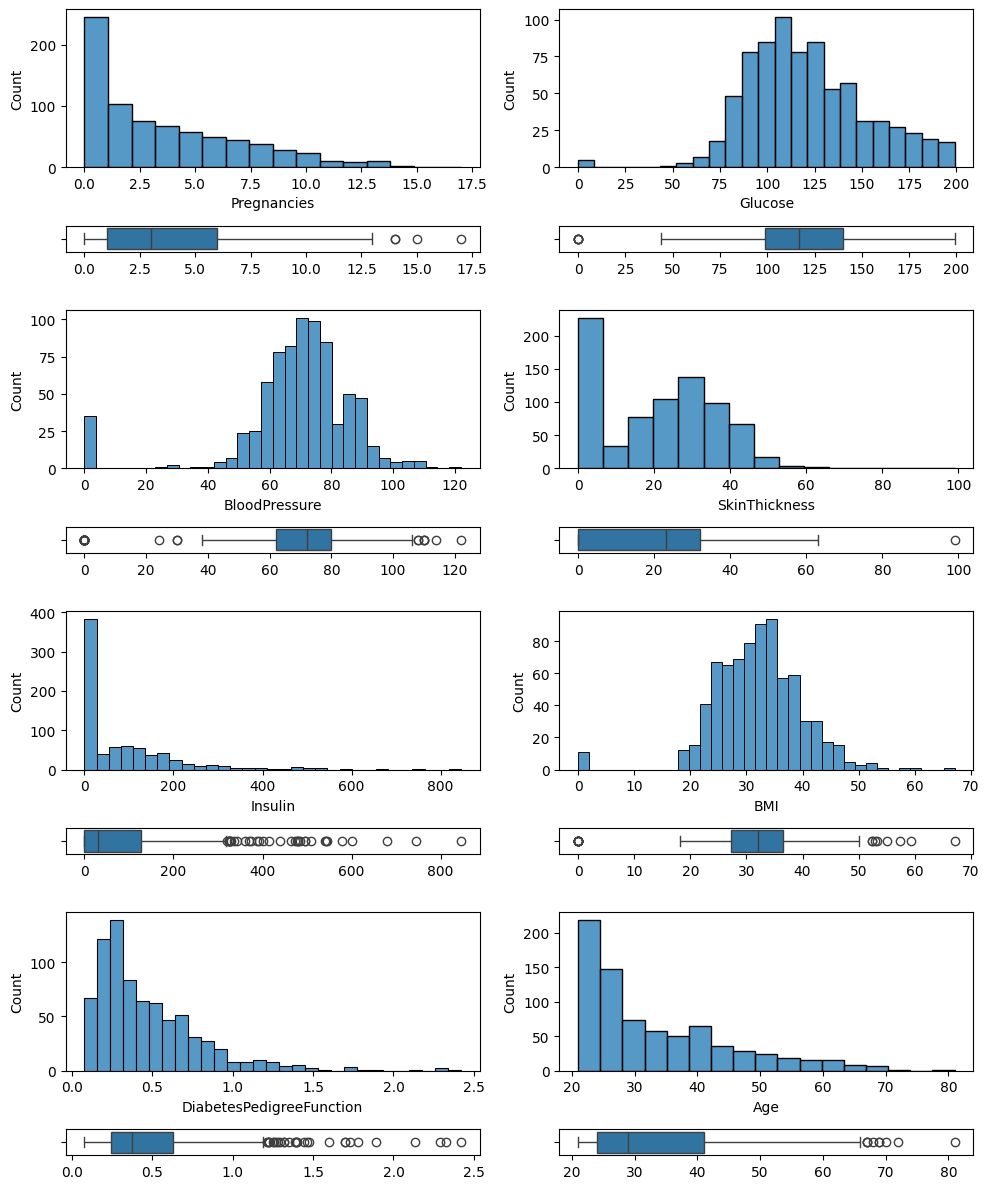

In [928]:
features = df.drop(columns=["Outcome"]).columns

fig, ax = plt.subplots(len(features), 2, figsize=(10, 12), 
                       gridspec_kw={'height_ratios': [6, 1] * (len(features) // 2)})

for i, feature in enumerate(features):
    row = (i // 2) * 2 
    col = i % 2
    sns.histplot(ax=ax[row, col], data=df, x=feature)
    sns.boxplot(ax=ax[row + 1, col], data=df, x=feature).set(xlabel=None)


plt.tight_layout()
plt.show()

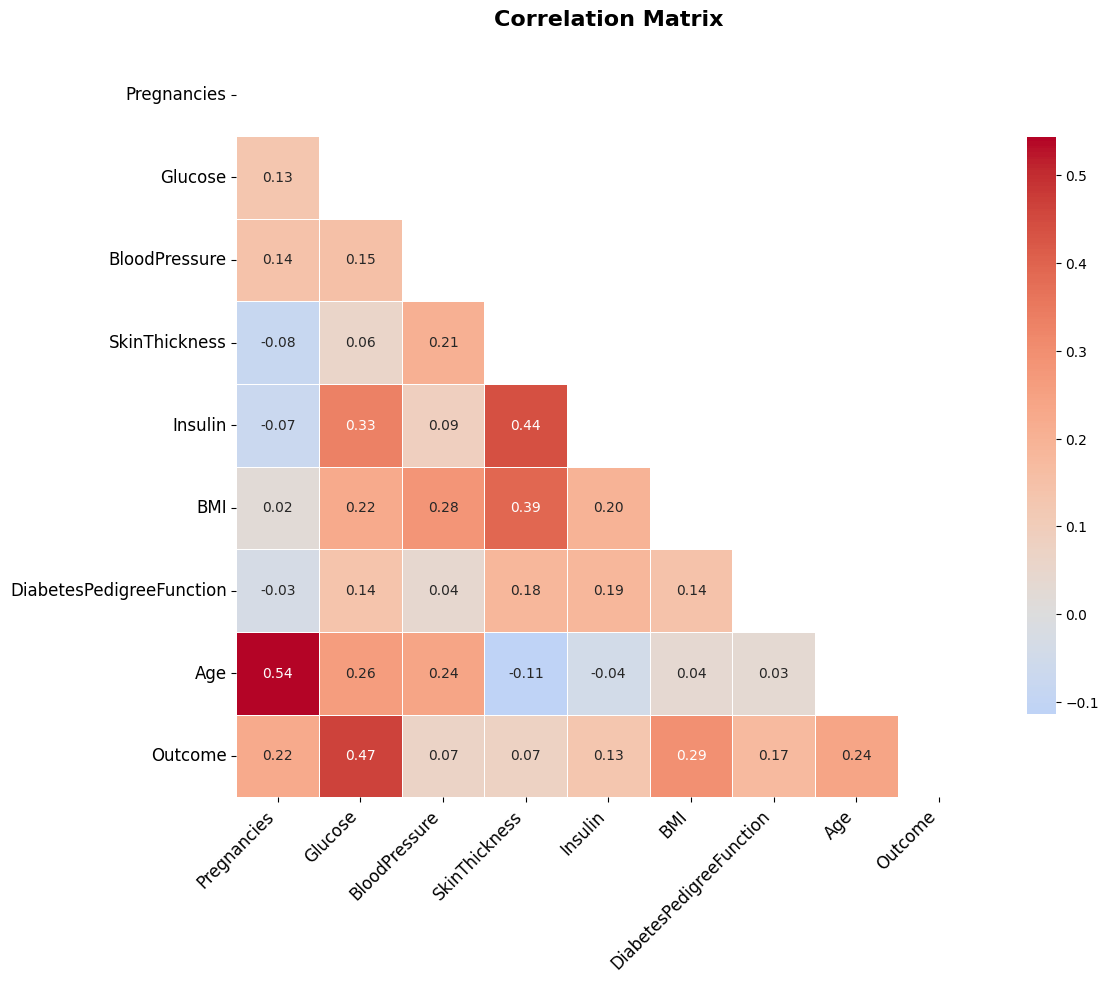

In [929]:
# Correlation heatmap
plt.figure(figsize=(12, 10))

corr_matrix = df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix, 
    mask=mask,
    annot=True, 
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.75},
    annot_kws={"size": 10}
)

plt.title("Correlation Matrix", fontsize=16, fontweight="bold", pad=20)
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12)

plt.show()

In [930]:
def identify_outliers(df):
    outlier_info = {}

    for col in df.select_dtypes(include='number').columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1 

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        if not outliers.empty:
            outlier_info[col] = {
                'outliers_count': outliers.shape[0],
                'lower_bound': lower_bound,
                'upper_bound': upper_bound,
                'outlier_values': outliers[col].tolist()
            }

    for col, info in outlier_info.items():
        print(f"Column: {col}")
        print(f"  Number of outliers: {info['outliers_count']}")
        print(f"  Low Limit: {info['lower_bound']}")
        print(f"  High Limit: {info['upper_bound']}")
        print(f"  Outliers: {info['outlier_values'][:5]}...\n")
    return outlier_info

In [931]:
outlier_info = identify_outliers(df)

Column: Pregnancies
  Number of outliers: 4
  Low Limit: -6.5
  High Limit: 13.5
  Outliers: [15, 17, 14, 14]...

Column: Glucose
  Number of outliers: 5
  Low Limit: 37.125
  High Limit: 202.125
  Outliers: [0, 0, 0, 0, 0]...

Column: BloodPressure
  Number of outliers: 45
  Low Limit: 35.0
  High Limit: 107.0
  Outliers: [0, 0, 30, 110, 0]...

Column: SkinThickness
  Number of outliers: 1
  Low Limit: -48.0
  High Limit: 80.0
  Outliers: [99]...

Column: Insulin
  Number of outliers: 34
  Low Limit: -190.875
  High Limit: 318.125
  Outliers: [543, 846, 342, 495, 325]...

Column: BMI
  Number of outliers: 19
  Low Limit: 13.35
  High Limit: 50.550000000000004
  Outliers: [0.0, 0.0, 0.0, 0.0, 53.2]...

Column: DiabetesPedigreeFunction
  Number of outliers: 29
  Low Limit: -0.32999999999999996
  High Limit: 1.2
  Outliers: [2.288, 1.441, 1.39, 1.893, 1.781]...

Column: Age
  Number of outliers: 9
  Low Limit: -1.5
  High Limit: 66.5
  Outliers: [69, 67, 72, 81, 67]...



In [932]:
def remove_outliers(df, outlier_info):
    
    for col, info in outlier_info.items():
        lower_limit = info['lower_bound']
        upper_limit = info['upper_bound']
        
        if lower_limit < 0:
            df = df[df[col] >= lower_limit]
        if upper_limit > 0:
            df = df[df[col] <= upper_limit]

        
    return df

def cap_outliers(series, low_limit, high_limit):
    return np.clip(series, low_limit, high_limit)

def transform_outliers(df, outlier_info):
    for col, info in outlier_info.items():
        lower_limit = info['lower_bound']
        upper_limit = info['upper_bound']
        
        if col in ['Glucose', 'BloodPressure', 'BMI'] and 0 in df[col].values:
            df[col] = df[col].replace(0, df[col].median())
            
        if col == 'Pregnancies':
            df[col] = cap_outliers(df[col], lower_limit, upper_limit)
        elif col == 'BloodPressure':
            df[col] = cap_outliers(df[col], lower_limit, upper_limit)
        elif col == 'SkinThickness':
            df[col] = cap_outliers(df[col], lower_limit, upper_limit)
        elif col == 'Insulin':
            df[col] = np.log1p(df[col])
        elif col == 'BMI':
            df[col] = cap_outliers(df[col], lower_limit, upper_limit)
        elif col == 'DiabetesPedigreeFunction':
            df[col] = np.log1p(df[col])
        elif col == 'Age':
            df[col] = cap_outliers(df[col], lower_limit, upper_limit)
            
    return df

In [933]:
df_without_outliers = remove_outliers(df, outlier_info=outlier_info)
df_without_outliers.describe().round(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,681.00,681.00,681.00,681.00,681.00,681.00,681.00,681.00,681.00
mean,3.77,118.06,68.50,19.71,62.06,31.59,0.43,32.51,0.32
std,3.27,30.67,19.18,15.55,78.61,7.38,0.25,10.93,0.47
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.00,0.24,24.00,0.00
50%,3.00,114.00,72.00,22.00,0.00,32.00,0.35,29.00,0.00
75%,6.00,136.00,80.00,32.00,115.00,35.90,0.58,40.00,1.00
max,13.00,198.00,106.00,60.00,318.00,50.00,1.19,66.00,1.00


In [934]:
df_transformed_outliers = transform_outliers(df=df.copy(), outlier_info=outlier_info)
df_transformed_outliers.describe().round(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.84,121.66,72.37,20.51,2.47,32.39,0.37,33.20,0.35
std,3.34,30.44,11.86,15.84,2.46,6.68,0.20,11.63,0.48
min,0.00,44.00,35.00,0.00,0.00,18.20,0.08,21.00,0.00
25%,1.00,99.75,64.00,0.00,0.00,27.50,0.22,24.00,0.00
50%,3.00,117.00,72.00,23.00,3.45,32.00,0.32,29.00,0.00
75%,6.00,140.25,80.00,32.00,4.85,36.60,0.49,41.00,1.00
max,13.50,199.00,107.00,80.00,6.74,50.55,1.23,66.50,1.00


In [935]:
def train_split(target, dataframe, test_size=0.1, random_state=42):
    return train_test_split(dataframe.drop(columns=target), dataframe[target], test_size=test_size, random_state=random_state)

In [936]:
def standard_scaler(X_train, X_test, filename: str):

    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train_norm = scaler.transform(X_train)
    X_test_norm = scaler.transform(X_test)

    X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=X_train.columns)
    X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=X_test.columns)

    dump(scaler, f'../data/processed/std_transform_{filename}.sav')

    return X_train_norm, X_test_norm

def min_max_scaler(X_train, X_test, reference: str):
    
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    
    X_train_minmax = scaler.transform(X_train)
    X_train_minmax = pd.DataFrame(X_train_minmax, index = X_train.index, columns=X_train.columns)

    X_test_minmax = scaler.transform(X_test)
    X_test_minmax = pd.DataFrame(X_test_minmax, index = X_test.index, columns=X_test.columns)
    
    dump(scaler, f'../data/processed/minmax_{reference}.sav')

    return X_train_minmax, X_test_minmax


In [937]:
X_train_with_outliers, X_test_with_outliers, y_train, y_test = train_split('Outcome', df)
X_train_without_outliers, X_test_without_outliers, y_train_without_outliers, y_test_without_outliers  = train_split('Outcome', df_without_outliers)
X_train_transformed_outliers, X_test_transformed_outliers, y_train_transformed_outliers, y_test_transformed_outliers= train_split('Outcome', df_transformed_outliers)

#Default
X_train_with_outliers.to_csv('../data/processed/X_train_with_outliers_ts_02_rs_42.csv', index=False)
X_test_with_outliers.to_csv('../data/processed/X_test_with_outliers_ts_02_rs_42.csv', index=False)

y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

#Without outliers
X_train_without_outliers.to_csv('../data/processed/X_train_without_outliers_ts_02_rs_42.csv', index=False)
X_test_without_outliers.to_csv('../data/processed/X_test_without_outliers_ts_02_rs_42.csv', index=False)

y_train_without_outliers.to_csv('../data/processed/y_train_without_outliers.csv', index=False)
y_test_without_outliers.to_csv('../data/processed/y_test_without_outliers.csv', index=False)

#Transformed outliers
X_train_transformed_outliers.to_csv('../data/processed/X_train_transformed_outliers_ts_02_rs_42.csv', index=False)
X_test_transformed_outliers.to_csv('../data/processed/X_train_transformed_outliers_ts_02_rs_42.csv', index=False)

y_train_transformed_outliers.to_csv('../data/processed/y_train_transformed_outliers.csv', index=False)
y_test_transformed_outliers.to_csv('../data/processed/y_test_transformed_outliers.csv', index=False)





In [938]:
X_train_with_outliers_std, X_test_with_outliers_std = standard_scaler(X_train_with_outliers, X_test_with_outliers, 'with_outliers')
X_train_without_outliers_std, X_test_without_outliers_std = standard_scaler(X_train_without_outliers, X_test_without_outliers, 'without_outliers')
X_train_transformed_outliers_std, X_test_transformed_outliers_std = standard_scaler(X_train_transformed_outliers, X_test_transformed_outliers, 'transformed_outliers')

X_train_with_outliers_minmax, X_test_with_outliers_minmax = min_max_scaler(X_train_with_outliers, X_test_with_outliers, 'with_outliers')
X_train_without_outliers_minmax, X_test_without_outliers_minmax = min_max_scaler(X_train_without_outliers, X_test_without_outliers, 'without_outliers')
X_train_transformed_outliers_minmax, X_test_transformed_outliers_minmax = min_max_scaler(X_train_transformed_outliers, X_test_transformed_outliers, 'transformed_outliers')



In [939]:
def select_k_best(X_train, X_test, y_train, k, filename: str):

    selection_model = SelectKBest(f_classif, k=k)
    selection_model.fit(X_train, y_train)
    cols = selection_model.get_support()

    dump(selection_model, f'../data/processed/selection_model_{filename}.sav')

    return pd.DataFrame(selection_model.transform(X_train), columns=X_train.columns.values[cols]) , pd.DataFrame(selection_model.transform(X_test), columns=X_test.columns.values[cols])

In [940]:
X_train_with_outliers_selected, X_test_with_outliers_selected = select_k_best(X_train_with_outliers, X_test_with_outliers, y_train, 'all', 'with_outliers')
X_train_without_outliers_selected, X_test_without_outliers_selected = select_k_best(X_train_without_outliers, X_test_without_outliers, y_train_without_outliers, 'all', 'without_outliers')
X_train_transformed_outliers_selected, X_test_transformed_outliers_selected = select_k_best(X_train_transformed_outliers, X_test_transformed_outliers, y_train_transformed_outliers, 'all', 'transformed_outliers')

In [941]:
X_train_with_outliers_std_selected = X_train_with_outliers_std[X_train_with_outliers_selected.columns]
X_train_without_outliers_std_selected = X_train_without_outliers_std[X_train_without_outliers_selected.columns]
X_train_transformed_outliers_std_selected = X_train_transformed_outliers_std[X_train_transformed_outliers_selected.columns]

X_test_with_outliers_std_selected = X_test_with_outliers_std[X_test_with_outliers_selected.columns]
X_test_without_outliers_std_selected = X_test_without_outliers_std[X_test_without_outliers_selected.columns]
X_test_transformed_outliers_std_selected = X_test_transformed_outliers_std[X_test_transformed_outliers_selected.columns]


X_train_with_outliers_minmax_selected = X_train_with_outliers_minmax[X_train_with_outliers_selected.columns]
X_train_without_outliers_minmax_selected = X_train_without_outliers_minmax[X_train_without_outliers_selected.columns]
X_train_transformed_outliers_minmax_selected = X_train_transformed_outliers_minmax[X_train_transformed_outliers_selected.columns]

X_test_with_outliers_minmax_selected = X_test_with_outliers_minmax[X_test_with_outliers_selected.columns]
X_test_without_outliers_minmax_selected = X_test_without_outliers_minmax[X_test_without_outliers_selected.columns]
X_test_transformed_outliers_minmax_selected = X_test_transformed_outliers_minmax[X_test_transformed_outliers_selected.columns]

In [942]:
dfs_train = {
    'X_train_with_outliers_selected': X_train_with_outliers_selected,
    'X_train_with_outliers_norm_selected': X_train_with_outliers_std_selected,
    'X_train_with_outliers_minmax_selected': X_train_with_outliers_minmax_selected,
}

dfs_train_without_outliers = {
    'X_train_without_outliers_selected': X_train_without_outliers_selected,
    'X_train_without_outliers_norm_selected': X_train_without_outliers_std_selected,
    'X_train_without_outliers_minmax_selected': X_train_without_outliers_minmax_selected 
}

dfs_train_transformed_outliers = {
    'X_train_transformed_outliers_selected': X_train_transformed_outliers_selected,
    'X_train_transformed_outliers_norm_selected': X_train_transformed_outliers_std_selected,
    'X_train_transformed_outliers_minmax_selected': X_train_transformed_outliers_minmax_selected 
}

dfs_test = {
    'X_test_with_outliers_selected': X_test_with_outliers_selected,
    'X_test_with_outliers_norm_selected': X_test_with_outliers_std_selected,
    'X_test_with_outliers_minmax_selected': X_test_with_outliers_minmax_selected,
}

dfs_test_without_outliers = {
    'X_test_without_outliers_selected': X_test_without_outliers_selected,
    'X_test_without_outliers_norm_selected': X_test_without_outliers_std_selected,
    'X_test_without_outliers_minmax_selected': X_test_without_outliers_minmax_selected
}

dfs_test_transformed_outliers = {
    'X_test_transformed_outliers_selected': X_test_transformed_outliers_selected,
    'X_test_transformed_outliers_norm_selected': X_test_transformed_outliers_std_selected,
    'X_test_transformed_outliers_minmax_selected': X_test_transformed_outliers_minmax_selected
}


for name, df in dfs_train.items():
    df.to_csv(f"../data/processed/{name}.csv", index=False)

for name, df in dfs_test.items(): 
    df.to_csv(f'../data/processed/{name}.csv', index=False)

for name, df in dfs_train_without_outliers.items():
    df.to_csv(f"../data/processed/{name}.csv", index=False)

for name, df in dfs_test_without_outliers.items(): 
    df.to_csv(f'../data/processed/{name}.csv', index=False)

for name, df in dfs_train_transformed_outliers.items():
    df.to_csv(f"../data/processed/{name}.csv", index=False)

for name, df in dfs_test_transformed_outliers.items(): 
    df.to_csv(f'../data/processed/{name}.csv', index=False)

In [954]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

train = list(dfs_train.values())
test = list(dfs_test.values())
train_without_outliers = list(dfs_train_without_outliers.values())
test_without_outliers = list(dfs_test_without_outliers.values())
train_transformed_outliers = list(dfs_train_transformed_outliers.values())
test_transformed_outliers = list(dfs_test_transformed_outliers.values())

results = []

# Default
for index, train_df in enumerate(train):
    model = DecisionTreeClassifier(random_state=42)
    model.fit(train_df, y_train)
    y_pred = model.predict(test[index])

    results.append({
        'index': index,
        'df_train': list(dfs_train.keys())[index],
        'Accuracy Score': round(accuracy_score(y_test, y_pred), 4),
        'Classification report': classification_report(y_test, y_pred),
        'Confusion matrix': confusion_matrix(y_test, y_pred)
    })

# Without outliers
for index, train_df in enumerate(train_without_outliers):
    model = DecisionTreeClassifier(random_state=42)
    model.fit(train_df, y_train_without_outliers)
    y_pred = model.predict(test_without_outliers[index])

    results.append({
        'index': index,
        'df_train': list(dfs_train_without_outliers.keys())[index],
        'Accuracy Score': round(accuracy_score(y_test_without_outliers, y_pred), 4),
        'Classification report': classification_report(y_test_without_outliers, y_pred),
        'Confusion matrix': confusion_matrix(y_test_without_outliers, y_pred)
    })

# Transformed outliers
for index, train_df in enumerate(train_transformed_outliers):
    model = DecisionTreeClassifier(random_state=42)
    model.fit(train_df, y_train_transformed_outliers)
    y_pred = model.predict(test_transformed_outliers[index])

    results.append({
        'index': index,
        'df_train': list(dfs_train_transformed_outliers.keys())[index],
        'Accuracy Score': round(accuracy_score(y_test_transformed_outliers, y_pred), 4),
        'Classification report': classification_report(y_test_transformed_outliers, y_pred),
        'Confusion matrix': confusion_matrix(y_test_transformed_outliers, y_pred)
    })


results = sorted(results, key=lambda x: x['Accuracy Score'], reverse=True)
best_result = results[0]

print(f"Index: {best_result['index']}")
print(f"\ndf_train: {best_result['df_train']}")
print(f"\nAccuracy Score: {best_result['Accuracy Score']}")
print(f"\nClassification Report: {best_result['Classification report']}")
print(f"\nConfusion Matrix: {best_result['Confusion matrix']}")


Index: 0

df_train: X_train_with_outliers_selected

Accuracy Score: 0.7922

Classification Report:               precision    recall  f1-score   support

           0       0.85      0.82      0.84        50
           1       0.69      0.74      0.71        27

    accuracy                           0.79        77
   macro avg       0.77      0.78      0.78        77
weighted avg       0.80      0.79      0.79        77


Confusion Matrix: [[41  9]
 [ 7 20]]


In [944]:
hyperparams = {
    "splitter": ["best"],
    "max_depth": [None, 10, 15, 20, 25, 30, 35, 40],
    "min_samples_split": [2, 3, 4, 5, 6, 7],
    "random_state": [42],
    "min_weight_fraction_leaf": [0.01, 0.015, 0.025, 0.05, 0.075, 0.1]
}

model = DecisionTreeClassifier(random_state=42)
model.fit(dfs_train.get(best_result["df_train"]), y_train)
grid = GridSearchCV(model, hyperparams, scoring = "accuracy", cv = 5)
grid.fit(dfs_train.get(best_result["df_train"]), y_train)
print(f'The best hyperparameters are: {grid.best_params_}')

The best hyperparameters are: {'max_depth': None, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.075, 'random_state': 42, 'splitter': 'best'}


In [945]:
model_grid = DecisionTreeClassifier(**grid.best_params_)
model_grid.fit(dfs_train.get(best_result["df_train"]), y_train)
y_pred = model_grid.predict(dfs_test.get(list(dfs_test)[best_result["index"]]))
model_grid_accuracy = round(accuracy_score(y_test, y_pred),4)

print(f'The model accuracy with the hyperparameters is: {model_grid_accuracy*100}%, an increase of {round(model_grid_accuracy-(results[0]["Accuracy Score"]),4)*100}% vs the default model')

The model accuracy with the hyperparameters is: 71.43%, an increase of -7.79% vs the default model


In [946]:
tree_rules = export_text(model_grid, feature_names = X_train_with_outliers.columns)
print(tree_rules)

|--- Glucose <= 127.50
|   |--- Age <= 28.50
|   |   |--- BMI <= 30.95
|   |   |   |--- Glucose <= 103.50
|   |   |   |   |--- class: 0
|   |   |   |--- Glucose >  103.50
|   |   |   |   |--- class: 0
|   |   |--- BMI >  30.95
|   |   |   |--- DiabetesPedigreeFunction <= 0.45
|   |   |   |   |--- class: 0
|   |   |   |--- DiabetesPedigreeFunction >  0.45
|   |   |   |   |--- class: 0
|   |--- Age >  28.50
|   |   |--- Glucose <= 99.50
|   |   |   |--- class: 0
|   |   |--- Glucose >  99.50
|   |   |   |--- DiabetesPedigreeFunction <= 0.29
|   |   |   |   |--- class: 0
|   |   |   |--- DiabetesPedigreeFunction >  0.29
|   |   |   |   |--- class: 1
|--- Glucose >  127.50
|   |--- BMI <= 29.95
|   |   |--- class: 0
|   |--- BMI >  29.95
|   |   |--- Glucose <= 157.50
|   |   |   |--- class: 1
|   |   |--- Glucose >  157.50
|   |   |   |--- class: 1



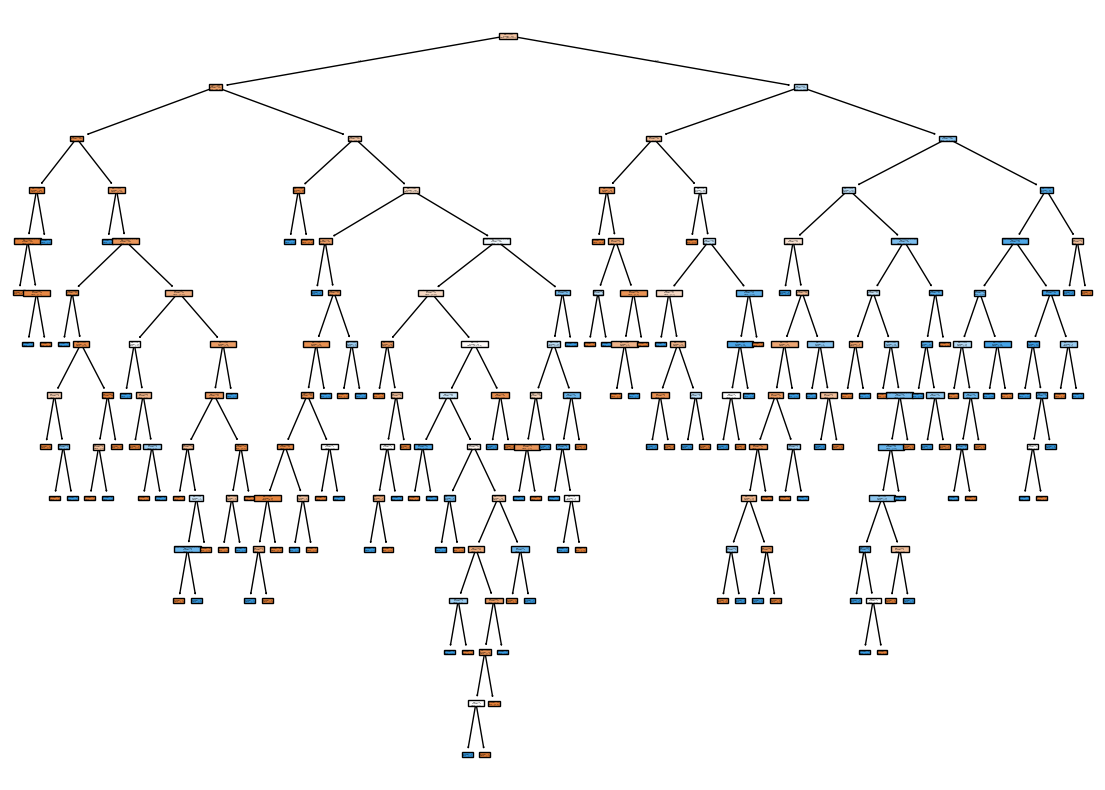

In [947]:
plt.figure(figsize=(14,10))

plot_tree(
    model, 
    feature_names = X_train_with_outliers.columns, 
    filled = True
)

plt.show()